In [82]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xbg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

# Feature Exploration, Engineering and Cleaning

In [83]:
train=pd.read_csv('./input/train.csv')
test=pd.read_csv('./input/test.csv')

PassengerId=test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [84]:
full_data=[train,test]

train['Name_length']=train['Name'].apply(len)
test['Name_length']=test['Name'].apply(len)

train['Has_Cabin']=train['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
test['Has_Cabin']=test['Cabin'].apply(lambda x:0 if type(x)==float else 1)

for dataset in full_data:
    dataset['FamilySize']=dataset['SibSp']+dataset['Parch']+1
    
for dataset in full_data:
    dataset['IsAlone']=0
    dataset.loc[dataset['FamilySize']==1,'IsAlone']=1

for dataset in full_data:
    dataset['Embarked']=dataset['Embarked'].fillna('S')
    
for dataset in full_data:
    dataset['Fare']=dataset['Fare'].fillna(train['Fare'].median())
    
train['CategoricalFare']=pd.qcut(train['Fare'],4)

for dataset in full_data:
    age_avg=dataset['Age'].mean()
    age_std=dataset['Age'].std()
    age_null_count=dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])]=age_null_random_list
    dataset['Age']=dataset['Age'].astype(int)

train['CategoricalAge']=pd.cut(train['Age'],5)

def get_title(name):
    title_search=re.search(' ([A-Za-z]+)\.',name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title']=dataset['Name'].apply(get_title)
    
for dataset in full_data:
    dataset['Title']=dataset['Title'].replace(['Lady','Countes','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
    dataset['Title']=dataset['Title'].replace('Mile','Miss')
    dataset['Title']=dataset['Title'].replace('Mme','Mrs')
    
for dataset in full_data:
    dataset['Sex']=dataset['Sex'].map({'female':0,'male':1}).astype(int)
    
    title_mapping={'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Rare':5}
    dataset['Title']=dataset['Title'].map(title_mapping)
    dataset['Title']=dataset['Title'].fillna(0)
    
    dataset['Embarked']=dataset['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
    
    dataset.loc[dataset['Fare']<=7.91,'Fare']
    dataset.loc[(dataset['Fare']>7.91)&(dataset['Fare']<=14.454),'Fare']=1
    dataset.loc[(dataset['Fare']>14.454)&(dataset['Fare']<=31),'Fare']=2
    dataset.loc[dataset['Fare']>31,'Fare']=3
    dataset['Fare']=dataset['Fare'].astype(int)
    
    dataset.loc[dataset['Age']<=16,'Age']=0
    dataset.loc[(dataset['Age']>16)&(dataset['Age']<32),'Age']=1
    dataset.loc[(dataset['Age']>32)&(dataset['Age']<48),'Age']=2
    dataset.loc[(dataset['Age']>48)&(dataset['Age']<=64),'Age']=3
    dataset.loc[dataset['Age']>64,'Age']=4

In [85]:
drop_elements=['PassengerId','Name','Ticket','Cabin','SibSp']
train=train.drop(drop_elements,axis=1)
train=train.drop(['CategoricalAge','CategoricalFare'],axis=1)
test=test.drop(drop_elements,axis=1)

# Visualisations

In [86]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,7,0,23,0,2,0,1.0
1,1,1,0,2,0,3,1,51,1,2,0,3.0
2,1,3,0,1,0,1,0,22,0,1,1,2.0


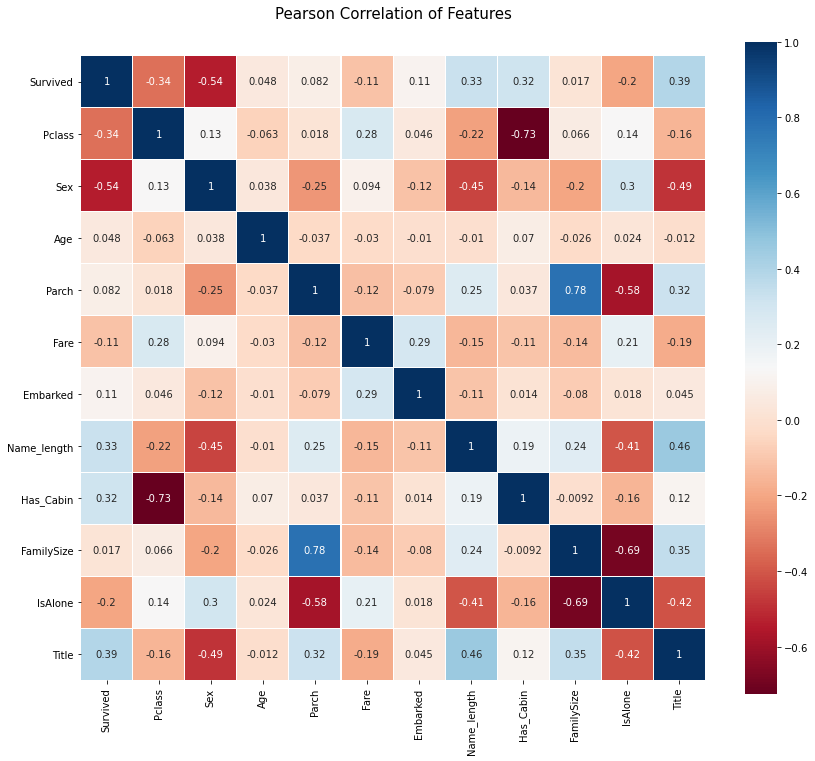

In [87]:
# Pearson Corrleation Heatmap
colormap=plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features',y=1.05,size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,linecolor='white',annot=True)

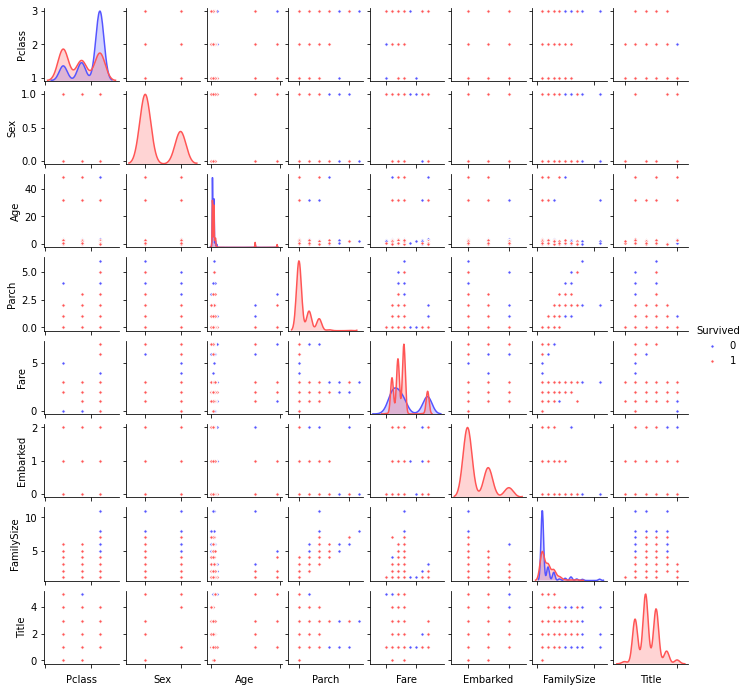

In [88]:
# Pariplots
g=sns.pairplot(train[[u'Survived',u'Pclass',u'Sex',u'Age',u'Parch',u'Fare',u'Embarked',u'FamilySize',u'Title']],hue='Survived',palette='seismic',size=1.2,diag_kind='kde',diag_kws=dict(shade=True),plot_kws=dict(s=10))
g.set(xticklabels=[])

# Ensembling & Stacking models

Helpers via Python Classes

In [89]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=SEED)

class SKlearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        return self.clf.fit(x, y).feature_importances_

Out-of-Fold Predictions 

In [90]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain, ))
    oof_test = np.zeros((ntest, ))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_train, y_train)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
    
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generatig our Base First-Level Models

In [91]:
# Random Forest parameters
rf_params={
    'n_jobs':-1,
    'n_estimators':500,
    'warm_start':True,
    'max_depth':6,
    'min_samples_leaf':2,
    'max_features':'sqrt',
    'verbose':0
}

# Extra Trees Parameters
et_params={
    'n_jobs':-1,
    'n_estimators':500,
    'max_depth':8,
    'min_samples_leaf':2,
    'verbose':0
}

# AdaBoost Parameters
ada_params={
    'n_estimators':500,
    'learning_rate':0.75
}

# Gradient Boosting Parameters
gb_params={
    'n_estimators':500,
    'max_depth':5,
    'min_samples_leaf':2,
    'verbose':0
}

# Support Vector Classifier Parameters
svc_params={
    'kernel':'linear',
    'C':0.025
}

In [92]:
rf=SklearnHelper(clf=RandomForestClassifier,seed=SEED,params=rf_params)
et=SklearnHelper(clf=ExtraTreesClassifier,seed=SEED,params=et_params)
ada=SklearnHelper(clf=AdaBoostClassifier,seed=SEED,params=ada_params)
gb=SklearnHelper(clf=GradientBoostingClassifier,seed=SEED,params=gb_params)
svc=SklearnHelper(clf=SVC,seed=SEED,params=svc_params)

Creating Numpy as arrays out of our train and test sets

In [93]:
y_train=train['Survived'].ravel()
train=train.drop(['Survived'],axis=1)
x_train=train.values
x_test=test.values

Output of the First level Predictions

In [94]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

print('Training is complete')

Training is complete


Feature importances generated from the differnet classifiers

In [95]:
rf_feature=rf.feature_importances(x_train,y_train)
et_feature=et.feature_importances(x_train,y_train)
ada_feature=ada.feature_importances(x_train,y_train)
gb_feature=gb.feature_importances(x_train,y_train)

[0.11368549 0.2428542  0.04193731 0.01792005 0.03625001 0.02322231
 0.1101979  0.07005462 0.07319944 0.01103653 0.25964214]
[0.12357467 0.41256471 0.02832727 0.01694251 0.03587823 0.02825169
 0.04773976 0.08933958 0.04206867 0.02447144 0.15084147]
[0.026 0.002 0.064 0.052 0.036 0.01  0.658 0.002 0.052 0.006 0.092]
[0.11316854 0.34505797 0.07394707 0.01167671 0.05075858 0.02154483
 0.19406165 0.04581694 0.08067622 0.00727614 0.05601535]


In [97]:
rf_features=[0.11368549,0.2428542,0.04193731,0.01792005,0.03625001,0.02322231,0.1101979,0.07005462,0.07319944,0.01103653,0.25964214]
et_features=[0.12357467,0.41256471,0.02832727,0.01694251,0.03587823,0.02825169,0.04773976,0.08933958,0.04206867,0.02447144,0.15084147]
ada_features=[0.026, 0.002, 0.064, 0.052, 0.036, 0.01 , 0.658, 0.002, 0.052, 0.006, 0.092]
gb_features=[0.11316854, 0.34505797, 0.07394707, 0.01167671, 0.05075858, 0.02154483, 0.19406165, 0.04581694, 0.08067622, 0.00727614, 0.05601535]

In [100]:
cols=train.columns.values

feature_dataframe=pd.DataFrame({'features':cols,
                                'Random Forest feature importances':rf_features,
                                'Extra Trees feature importances':et_features,
                                'AdaBoost feature importances':ada_features,
                                'Gradient Boost feature importances':gb_features})

Interactive feature importances via Plotly scatterplots

In [102]:
trace=go.Scatter(y=feature_dataframe['Random Forest feature importances'].values,
                x=feature_dataframe['features'].values,
                mode='markers',
                marker=dict(sizemode='diameter',sizeref=1,size=25,color=feature_dataframe['Random Forest feature importances'].values,colorscale='Portland',showscale=True),
                text=feature_dataframe['features'].values)
data=[trace]

layout=go.Layout(autosize=True,
                title='Random Forest Feature Importance',
                hovermode='closest',
                yaxis=dict(title='Feature Importance',ticklen=5,gridwidth=2),
                showlegend=False)
fig=go.Figure(data=data,layout=layout)
py.iplot(fig,filename='scatter2010')

In [105]:
trace=go.Scatter(y=feature_dataframe['Extra Trees feature importances'].values,
                x=feature_dataframe['features'].values,
                mode='markers',
                marker=dict(sizemode='diameter',
                           sizeref=1,
                           size=25,
                           color=feature_dataframe['Extra Trees feature importances'].values,
                           colorscale='Portland',
                           showscale=True),
                text=feature_dataframe['features'].values)
data=[trace]
layout=go.Layout(autosize=True,
                title='Extra Trees Feature Importance',
                hovermode='closest',
                yaxis=dict(title='Feature Importance',ticklen=5,gridwidth=2),
                showlegend=False)
fig=go.Figure(data=data,layout=layout)
py.iplot(fig,filename='scatter2010')

In [107]:
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(sizemode = 'diameter',sizeref = 1,size = 25,
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',showscale=True),
    text = feature_dataframe['features'].values)
data = [trace]
layout= go.Layout(autosize= True,
                  title= 'AdaBoost Feature Importance',
                  hovermode= 'closest',
                  yaxis=dict(title= 'Feature Importance',ticklen= 5,gridwidth= 2),
    showlegend= False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [109]:
trace=go.Scatter(y=feature_dataframe['Gradient Boost feature importances'].values,
                x=feature_dataframe['features'].values,
                mode='markers',
                marker=dict(sizemode='diameter',sizeref=1,size=25,
                           color=feature_dataframe['Gradient Boost feature importances'].values,
                           colorscale='Portland',
                           showscale=True),
                text=feature_dataframe['features'].values)
data=[trace]
layout=go.Layout(autosize=True,
                title='Gradient Boosting Feature Importace',
                hovermode='closest',
                yaxis=dict(title='Feature Importance',ticklen=5,gridwidth=2),
                showlegend=False)
fig=go.Figure(data=data,layout=layout)
py.iplot(fig,filename='scatter2010')

In [110]:
feature_dataframe['mean']=feature_dataframe.mean(axis=1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.113685,0.123575,0.026,0.113169,0.094107
1,Sex,0.242854,0.412565,0.002,0.345058,0.250619
2,Age,0.041937,0.028327,0.064,0.073947,0.052053


Plotly Barplot of Average Feature Importances

In [113]:
y=feature_dataframe['mean'].values
x=feature_dataframe['features'].values
data = [go.Bar(x= x, y= y, width = 0.5,
               marker=dict(color = feature_dataframe['mean'].values,
                           colorscale='Portland',
                           showscale=True,
                           reversescale = False),
               opacity=0.6)]
layout=go.Layout(autosize=True,title='Barplots of Mean Feature Importance',
                hovermode='closest',
                yaxis=dict(title='Feature Importance',ticklen=5,gridwidth=2),
                showlegend=False)
fig=go.Figure(data=data,layout=layout)
py.iplot(fig,filename='bar-direct-labels')

# Second-Level Predictions from the First-level Output

First-level output as new features

In [116]:
base_predictions_train=pd.DataFrame({'RandomForest':rf_oof_train.ravel(),
                                    'ExtraTrees':et_oof_train.ravel(),
                                     'AdaBoost':ada_oof_train.ravel(),
                                    'GradientBoost':gb_oof_train.ravel()})
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


Correlation Heatmap of the Second Level Training set

In [117]:
data=[go.Heatmap(z=base_predictions_train.astype(float).corr().values,
                x=base_predictions_train.columns.values,
                y=base_predictions_train.columns.values,
                colorscale='Viridis',
                showscale=True,
                reversescale=True)]
py.iplot(data,filename='labelled-heatmap')

In [118]:
x_train=np.concatenate((et_oof_train,rf_oof_train,ada_oof_train,gb_oof_train,svc_oof_train),axis=1)
x_test=np.concatenate((et_oof_test,rf_oof_test,ada_oof_test,gb_oof_test,svc_oof_test),axis=1)

Second level learning model via XGBoost

In [119]:
gbm=xbg.XGBClassifier(n_estimators=2000,max_depth=4,min_child_weight=2,
                     gamma=0.9,subsample=0.8,colsamples_bytree=0.8,objective='binary:logistic',
                     nthread=-1,scale_pos_weight=1).fit(x_train,y_train)
predictions=gbm.predict(x_test)

[14:47:00] WARNING: ..\src\learner.cc:541: 
Parameters: { colsamples_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:47:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Producting the Submission file

In [120]:
StackingSubmission=pd.DataFrame({'PassengerId':PassengerId,
                                'Survived':predictions})
StackingSubmission.to_csv('StackingSubmission.csv',index=False)